In [262]:
from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import os
import numpy as np
# import tensorflow_probability as tfp
import tensorflow as tf

In [263]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)
    print(X_t[:5])
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non Fraud', s=2)
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud', s=2)
    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();

def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log',basey=10)
    plt.show()

In [264]:
raw_data = pd.read_csv("creditcard.csv")
raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [265]:
raw_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [266]:
raw_data.loc[:,'Time'] = raw_data['Time'].apply(lambda x : x / 3600 % 24)

In [267]:
raw_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,14.537951,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,5.847061,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,10.598194,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,15.010833,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,19.329722,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,23.999444,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [268]:
raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class
0    284315
1       492
Name: count, dtype: int64


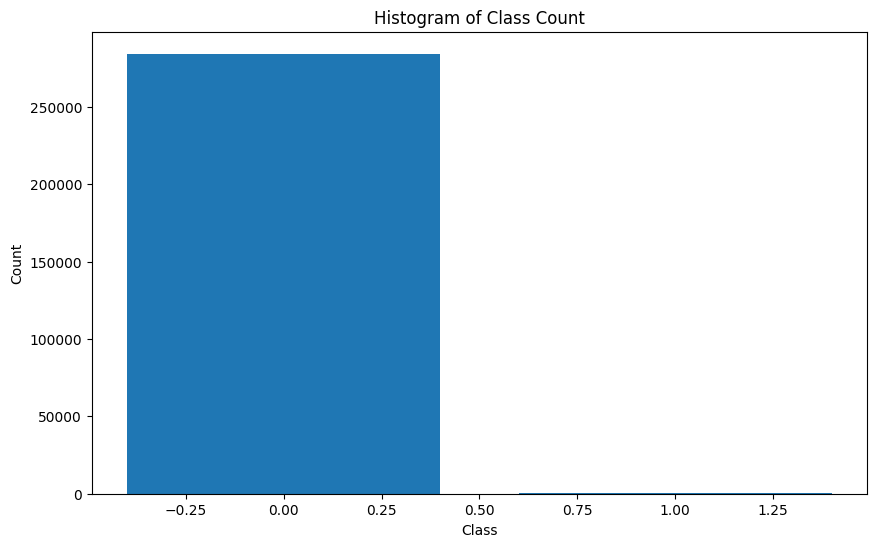

In [269]:
import matplotlib.pyplot as plt

# Assuming 'class' is the column name containing the classes
class_counts = raw_data['Class'].value_counts()
print(class_counts)
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Histogram of Class Count')
plt.show()


In [270]:
nonfraud = raw_data[raw_data['Class']==0].sample(1000)
fraud = raw_data[raw_data['Class']==1]

print(nonfraud.shape , fraud.shape)

df = pd.concat([nonfraud,fraud]).sample(frac=1).reset_index(drop=True)




# final = np.concatenate([nonfraud,fraud])
Y = df['Class']
final1 = df.drop(['Class'],axis=1)


final1.shape

(1000, 31) (492, 31)


(1492, 30)

[[ 33.386166   26.557695 ]
 [  8.4648075   5.0345774]
 [ 36.27036    24.625874 ]
 [-25.115236  -33.745968 ]
 [ 29.483753  -31.857065 ]]


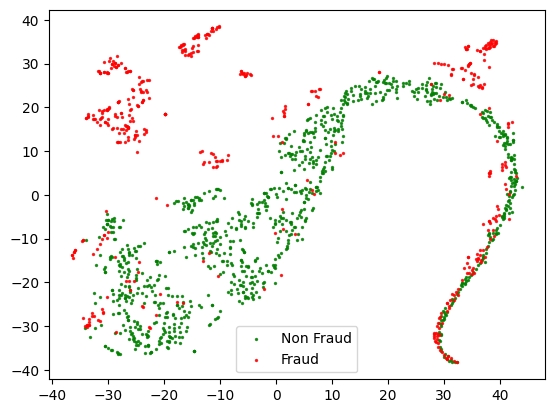

In [271]:

tsne_plot(final1 ,Y)

In [272]:
y = raw_data['Class']
rawdata = raw_data.drop(["Class"],axis=1)

In [273]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [274]:
data, data_test ,y_train,y_test= train_test_split(rawdata,y, test_size=0.25)

In [275]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(data)
data_test = scaler.transform(data_test)


In [276]:
data1 = pd.DataFrame(data)
data1.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.965576,-0.411951,1.584597,0.051270,3.402212,0.905391,0.428630,0.446772,0.361372,-2.265904,...,0.353334,-0.027855,0.009249,-0.757685,0.758808,1.233850,1.301702,-0.329447,0.268488,-0.321609
1,0.734148,-1.654193,-1.913663,1.273024,-0.038296,2.701428,-1.193121,-1.791643,0.566311,0.401450,...,1.170091,0.676382,0.544128,0.221915,0.327099,1.747414,-0.225536,-0.186608,0.387110,-0.308901
2,-0.204555,0.455335,-0.145430,0.271353,0.875365,-0.348381,-0.119433,-0.020026,0.118391,-0.056004,...,-0.009562,0.251595,0.315197,-0.196484,0.312991,0.745245,-0.698922,0.007645,0.095974,0.148923
3,-0.952029,0.699855,-0.429868,0.299759,-0.299568,-0.917937,-0.639916,-0.523053,-0.061207,-0.169123,...,-0.050030,-0.045580,-0.159080,-0.037217,0.627170,0.949755,-0.497401,0.000791,0.037190,-0.261347
4,0.488112,0.505778,-1.291903,-0.104707,0.956317,-1.293009,-0.122249,-0.252582,0.025963,1.652142,...,0.844278,0.148545,-0.579725,-0.029252,0.690575,-1.384928,0.107884,-0.176012,0.142169,1.539643


In [277]:
data1.describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,...,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05,2.136050e+05
mean,3.548888e-16,1.017057e-17,1.064459e-17,-6.923139e-18,9.031266e-18,-8.981369e-18,1.732240e-17,3.193376e-18,3.376330e-18,1.314773e-17,...,1.596688e-18,9.646656e-19,-1.977564e-17,-4.058248e-18,-2.029124e-18,4.307731e-18,2.574867e-17,8.906525e-18,-1.338889e-18,6.305254e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-2.486904e+00,-2.892466e+01,-4.401355e+01,-3.196064e+01,-3.954308e+00,-8.213420e+01,-1.957223e+01,-3.504192e+01,-4.281216e+01,-1.213591e+01,...,-7.051433e+01,-3.113042e+01,-1.506515e+01,-7.104138e+01,-4.674101e+00,-1.971470e+01,-5.394983e+00,-5.569231e+01,-4.705091e+01,-3.483261e-01
25%,-6.746197e-01,-4.731197e-01,-3.606940e-01,-5.881848e-01,-5.994483e-01,-5.000453e-01,-5.755601e-01,-4.462613e-01,-1.741863e-01,-5.865533e-01,...,-2.738858e-01,-3.111261e-01,-7.482773e-01,-2.574254e-01,-5.842065e-01,-6.071656e-01,-6.763287e-01,-1.749988e-01,-1.607040e-01,-3.259499e-01
50%,8.003145e-02,8.418472e-03,4.016091e-02,1.187602e-01,-1.365201e-02,-4.039283e-02,-2.047150e-01,3.218457e-02,2.052763e-02,-4.639189e-02,...,-8.146425e-02,-3.934022e-02,9.614723e-03,-1.866235e-02,6.969019e-02,2.963779e-02,-1.071347e-01,3.060208e-03,3.551372e-02,-2.615048e-01
75%,8.204224e-01,6.729548e-01,4.865852e-01,6.775815e-01,5.249190e-01,4.411080e-01,2.979423e-01,4.582466e-01,2.762466e-01,5.445684e-01,...,1.719515e-01,2.542650e-01,7.288737e-01,2.328777e-01,7.255677e-01,6.713182e-01,4.990140e-01,2.233719e-01,2.396669e-01,-4.445145e-02
max,1.619946e+00,1.256760e+00,1.335249e+01,6.204824e+00,1.192017e+01,2.512918e+01,5.483875e+01,9.701734e+01,1.681558e+01,1.420963e+01,...,5.100693e+01,3.699749e+01,1.145826e+01,3.571650e+01,7.560326e+00,1.162697e+01,7.286609e+00,7.801880e+01,1.032160e+02,1.010399e+02


In [278]:
data1.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.965576,-0.411951,1.584597,0.051270,3.402212,0.905391,0.428630,0.446772,0.361372,-2.265904,...,0.353334,-0.027855,0.009249,-0.757685,0.758808,1.233850,1.301702,-0.329447,0.268488,-0.321609
1,0.734148,-1.654193,-1.913663,1.273024,-0.038296,2.701428,-1.193121,-1.791643,0.566311,0.401450,...,1.170091,0.676382,0.544128,0.221915,0.327099,1.747414,-0.225536,-0.186608,0.387110,-0.308901
2,-0.204555,0.455335,-0.145430,0.271353,0.875365,-0.348381,-0.119433,-0.020026,0.118391,-0.056004,...,-0.009562,0.251595,0.315197,-0.196484,0.312991,0.745245,-0.698922,0.007645,0.095974,0.148923
3,-0.952029,0.699855,-0.429868,0.299759,-0.299568,-0.917937,-0.639916,-0.523053,-0.061207,-0.169123,...,-0.050030,-0.045580,-0.159080,-0.037217,0.627170,0.949755,-0.497401,0.000791,0.037190,-0.261347
4,0.488112,0.505778,-1.291903,-0.104707,0.956317,-1.293009,-0.122249,-0.252582,0.025963,1.652142,...,0.844278,0.148545,-0.579725,-0.029252,0.690575,-1.384928,0.107884,-0.176012,0.142169,1.539643


In [279]:
y_train.shape , y_test.shape

((213605,), (71202,))

In [280]:
data.shape , data1.shape

((213605, 30), (213605, 30))

In [281]:
from tensorflow.keras import backend as K

In [282]:
input = tf.keras.layers.Input(shape=(30,))

x = tf.keras.layers.Dense(20,activation="relu")(input)
x = tf.keras.layers.Dense(10,activation="relu")(x)
x = tf.keras.layers.Dense(8,activation="relu")(x)

mu = tf.keras.layers.Dense(2)(x)
log_var = tf.keras.layers.Dense(2)(x)


def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling)([mu, log_var])

decoder_input = tf.keras.layers.Input(shape=(2,))
x1 = tf.keras.layers.Dense(10,activation="relu")(decoder_input)
x1 = tf.keras.layers.Dense(20,activation="relu")(x1)
x1 = tf.keras.layers.Dense(30,activation="sigmoid")(x1)



model1 = tf.keras.Model(inputs=input, outputs=[mu , log_var ,z])
model2 = tf.keras.Model(inputs=decoder_input, outputs=x1)

out = model2(model1(input))

model = tf.keras.Model(inputs=input, outputs=out)


In [283]:
model1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 dense_12 (Dense)            (None, 20)                   620       ['input_4[0][0]']             
                                                                                                  
 dense_13 (Dense)            (None, 10)                   210       ['dense_12[0][0]']            
                                                                                                  
 dense_14 (Dense)            (None, 8)                    88        ['dense_13[0][0]']            
                                                                                            

In [284]:
model2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_17 (Dense)            (None, 10)                30        


                                                                 
 dense_18 (Dense)            (None, 20)                220       
                                                                 
 dense_19 (Dense)            (None, 30)                630       
                                                                 
Total params: 880 (3.44 KB)
Trainable params: 880 (3.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [285]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 model_3 (Functional)        [(None, 2),                  954       ['input_4[0][0]']             
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 model_4 (Functional)        (None, 30)                   880       ['model_3[0][0]',             
                                                                     'model_3[0][1]',       

In [286]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [287]:
model.compile(optimizer='adam', loss=vae_loss)

In [288]:
model.fit(data,y_train,epochs=10)

Epoch 1/10


ValueError: in user code:

    File "/home/AIapp/.local/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/AIapp/.local/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/AIapp/.local/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/AIapp/.local/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/AIapp/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/AIapp/.local/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_5' (type Functional).
    
    Layer "model_4" expects 1 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor 'model_5/model_3/dense_15/BiasAdd:0' shape=(None, 2) dtype=float32>, <tf.Tensor 'model_5/model_3/dense_16/BiasAdd:0' shape=(None, 2) dtype=float32>, <tf.Tensor 'model_5/model_3/lambda_1/add:0' shape=(None, 2) dtype=float32>]
    
    Call arguments received by layer 'model_5' (type Functional):
      • inputs=tf.Tensor(shape=(None, 30), dtype=float32)
      • training=True
      • mask=None
